<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Machine Learning Pipelines and GridSearchCV
Estimated time needed: **25** minutes
    

## Objectives

After completing this lab you will be able to:

- Build and evaluate a machine learning pipeline
- Implement GridSearchCV for hyperparameter tuning with crossvalidation
- Implement and optimize a complex classification pipeline using real-world data
- Extract feature importances from a trained pipeline


## Introduction
In machine learning workflows, the Pipeline class from Scikit-Learn is invaluable for streamlining data preprocessing and model training into a single, coherent sequence. A pipeline is essentially a sequence of data transformers that culminates with an optional final predictor. This structure enables seamless integration of preprocessing and predictive modeling, ensuring that the same data transformations applied during training are consistently applied to new data during prediction.

Each intermediate step in a pipeline must be a transformer, meaning it should implement both fit and transform methods. The final step, which is typically a predictive model, or estimator, only requires a fit method. The entire pipeline can be trained simultaneously using a method like GridSearchCV, resulting in self-contained predictor that can be used to make predictions on unseen data.

Importantly, the pipeline allows you to set the parameters of each of these steps using their names and parameter names connected by a double underscore `__`. For example, if a pipeline step is named `imputer` and you want to change its strategy, you can pass a parameter like `imputer__strategy='median'`. Additionally, steps can be entirely swapped out by assigning a different estimator or even bypassed by setting them to `'passthrough'` or `None`.

A major advantage of using a pipeline is that it enables comprehensive cross-validation and hyperparameter tuning for all steps simultaneously. By integrating the pipeline within GridSearchCV, you can fine-tune not only the model but also the preprocessing steps, leading to optimized overall performance. Pipelines are essential for scenarios where preprocessing involves estimators performing operations like scaling, encoding categorical variables, imputing missing values, and dimensionality reduction. Pipelines ensure these steps are reproducibly applied to both training and test data.


In this lab you will:
- Generate synthetic data for running targeted experiments using scikit-learn
- Train and evaluate a KNN classification model using a pipeline
- Tune model hyperparameters using a pipeline within a cross-validation grid search
- Build a more complex random forest classification pipeline using real-world data
- Extract the feature importances from the trained pipeline

Your goal in this lab is to learn how to build and optimize a complex machine learning model using a pipeline and crossvalidation to tune its hyperparameters.

The Practice Project, which follows next, is more hands-on. There you will participate by completing code segments and formulating responses to more open-ended questions.
The better you understand this lab, the easier the Practice Project and Final Project will be for you.


## Import the required libraries


First, to make sure that the required libraries are available, run the following cell.


In [1]:
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install seaborn==0.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 144.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 133.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.6
    Uninstalling matplotlib-3.10.6:
      Successfully uninstalled matplotlib-3.10.6


Now, you can import the required libraries and relevant functions.


In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Train a model using a pipeline
We'll start with an example of building a pipeline, fitting it to the Iris data, and evaluating its accuracy.


### Load the Iris data set


In [3]:
data = load_iris()
X, y = data.data, data.target
labels = data.target_names

### Instantiate a pipeline consisting of StandardScaler, PCA, and KNeighborsClassifier


In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Step 1: Standardize features
    ('pca', PCA(n_components=2),),       # Step 2: Reduce dimensions to 2 using PCA
    ('knn', KNeighborsClassifier(n_neighbors=5,))  # Step 3: K-Nearest Neighbors classifier
])

### Exercise 1. Split the data into training and test sets
Be sure to stratify the target.


In [5]:
# Enter your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<details><summary>Click here for the solution</summary>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
</details>


### Fit the pipeline on the training set
The pipeline consists of a sequence of three estimators, and should be viewed as the machine learning model we are training and testing.  
Let's go ahead and fit the model to the training data and evaluate its accuracy.


In [6]:
pipeline.fit(X_train, y_train)

# Measure the pipeline accuracy on the test data
test_score = pipeline.score(X_test, y_test)
print(f"{test_score:.3f}")

0.900


### Get the model predictions


In [7]:
y_pred = pipeline.predict(X_test)

### Exercise 2. Generate the confusion matrix for the KNN model and plot it


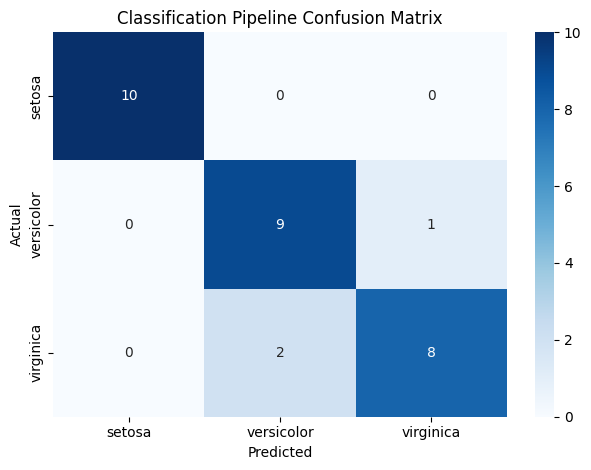

In [8]:
# Enter your code here
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a single plot for the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=labels, yticklabels=labels)

# Set the title and labels
plt.title('Classification Pipeline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

<details><summary>Click here for the solution</summary>
    
```python
# generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a plot for the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=labels, yticklabels=labels)

# Set the title and labels
plt.title('Classification Pipeline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()
```
</details>


### Exercise 3. Describe the errors made by the model.


<details><summary>Click here for the solution</summary>
The model incorectly classified two viginica irises as versicolor, and one versicolor as virginica. Not bad, only three classification errors out of 30 irises on our first attempt! 

</details>


## Tune hyperparameters using a pipeline within cross-validation grid search
We created a model but haven't yet attempted to optimize its performance.  Let's see if we can do better.
Recall that it would be a mistake to keep running the model over and over again with different hyperparamters to find the best one.  
You would effectively be overfiiting the model to your test data set.  
The correct way to handle this tuning is to use cross validation. 

Let's see how it works, using the same data set.


### Instantiate the pipeline
We'll preprocess the data by scaling it and transforming it onto a to-be-determined number of principle components, follow that up with a KNN model classifier, and combine these estimators into a pipeline. We'll then optimize the pipeline using crossvalidation over a hyperparameter grid search. This will allow us find the best model for the set of trial hyperparamters.


In [9]:
# make a pipeline without specifying any parameters yet
pipeline = Pipeline(
                    [('scaler', StandardScaler()),
                     ('pca', PCA()),
                     ('knn', KNeighborsClassifier()) 
                    ]
                   )

### Define a model parameter grid to search over


In [10]:
# Hyperparameter search grid for numbers of PCA components and KNN neighbors
param_grid = {'pca__n_components': [2, 3],
              'knn__n_neighbors': [3, 5, 7]
             }

### Choose a cross validation method
To ensure the target is stratified, we can use scikit-learn's `StratifiedKFold` cross-validation class.


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Exercise 4. Determine the best parameters
Pass your `pipeline`, `param_grid`, and the `StratifiedKFold` cross validation method to `GridSearchCV` 


In [13]:
# Enter your code here 
best_model = GridSearchCV(estimator=pipeline,
                          param_grid=param_grid,
                          cv=cv,
                          scoring='accuracy',
                          verbose=2
                         )

<details><summary>Click here for the solution</summary>
    
```python
best_model = GridSearchCV(estimator=pipeline,
                          param_grid=param_grid,
                          cv=cv,
                          scoring='accuracy',
                          verbose=2
                         )
```


### Fit the best `GridSearchCV` model to the training data


In [14]:
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'pca__n_components': [2, 3]},
             scoring='accuracy', verbose=2)

Go ahead and explore the `GridSearchCV` graphic that describes your estimator's structure, including the hyperparameters found for the best estimator.
You can get specific help on each components by clicking on its question mark.


### Exercise 5. Evaluate the accuracy of the best model on the test set


In [15]:
# Enter your code here
test_score = best_model.score(X_test, y_test)
print(f"{test_score:.3f}")

0.933


<details><summary>Click here for the solution</summary>
    
```python
test_score = best_model.score(X_test, y_test)
print(f"{test_score:.3f}")
```


We've made a great accuracy improvement from 90% to 93%.


### Display the best parameters


In [16]:
best_model.best_params_

{'knn__n_neighbors': 3, 'pca__n_components': 3}

### Plot the confusion matrix for the predictions on the test set


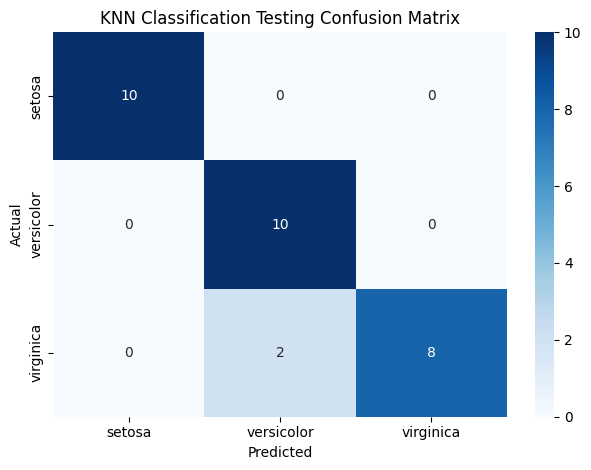

In [17]:
y_pred = best_model.predict(X_test)

# Generate the confusion matrix for KNN
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a single plot for the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=labels, yticklabels=labels)

# Set the title and labels
plt.title('KNN Classification Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()


That's impressive, only two errors where the predictions were Versicolor but the iris was actually a Virginica.

That conludes the lab. You are now equipped with an advanced methodolgy for building sophisticated machine learning models from the ground up. Still, there is much to learn of course. Digging into the rich set of examples from scikit-learn's website is a must. The help documentation is also fantastic. You'll learn something every time you look for certain. Of course, there is no substitude for gaining experience through practice.

Now it's time to roll up your sleeves and dive into a hands-on Practice Project.


### Congratulations! You've made it this far and are now equipped to complete your Practice Project in preparation for your final project!

## Author

<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>

### Other Contributor(s)

<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" taget="_blank">Abhishek Gagneja</a>


<!-- ## Changelog

| Date | Version | Changed by | Change Description |
|:------------|:------|:------------------|:---------------------------------------|
| 2024-11-20 | 1.0  | Jeff Grossman    | Create lab |

 -->
<h3 align="center"> © IBM Corporation. All rights reserved. <h3/>
